# Hamiltonian Simulation

Quantum Hamiltonian simulation is one of the most important problems in quantum computing. It consists in modeling the time evolution of a quantum system, ruled by some not natively executable Hamiltonian in a specific device. Simulations of this type are essential to comprehend quantum systems that are described by a complex dynamics, such as molecules in chemistry or materials in condensed matter physics, where classical computers fail due the exponential scale up required by larger quantum systems.

In this guide, you will be using Classiq to work with simple problems of Hamiltonian simulation using two different methods:

* **Trotter-Suzuki decomposition**
* **qDRIFT**

# Table of contents

1. [Importance](#Importance)
2. [Trotter-Suzuki decomposition](#trotter-suzuki-decomposition)
    * [Exponentiation with depth constraint](#exponentiation-with-depth-constraint)
3. [qDRIFT](#qDRIFT)
4. [Hamiltonian simulation with block encoding](#hamiltonian-simulation-with-block-encoding)
5. [Measuring the expected magnetization as a function of time](#measuring-the-expected-magnetization-as-a-function-of-time)
6. [Summary and Exercises](#summary-and-exercises)


# Importance

Quantum Hamiltonian simulation has several significant applications. Some of them are particularly interesting for physicists:

* Quantum Chemistry: It helps in predicting properties of molecules using quantum methods such as the Quantum Variational Eigensolver (VQE), which can be more efficiently than classical methods in certain conditions.
* Materials Science: It aids in designing new materials with desired properties by simulating their quantum mechanical behavior.
* Optimization and Machine Learning: Quantum simulations can be used to solve complex optimization problems and improve machine learning algorithms.

Mathematically, we can approach the Hamiltonian Simulation problem as the following: Suppose we have a quantum computer that can run natively the evolution operators of the set of Hamiltonians $\{H_j\}$. Now, suppose we want to understand the dynamics of the following, more complex, Hamiltonian:

<details><summary>What are the operations that this quantum computer can effectively execute?</summary>

If this quantum computer can only execute the evolution operators of the set of Hamiltonians $\{H_j\}$, then we could have only operations in the form:

$$O = \prod_{j} e^{-i \,\tau_j H_j}.$$
</details>


\begin{equation}
H_{full} = \sum_{j} h_j H_j,
\end{equation}

For some real values $h_j$. Therefore, we would need some kind of decomposition from the operator of Eq. (1) into our set of operations, formed by $\{e^{-itH_j}\}$, where $e^{-itH_j}$ is the evolution operator of the hamiltonian $H$.

## Trotter-Suzuki decomposition

Now that the problem is stated, a possible solution is the Trotter-Suzuki decomposition, also known as Trotterization. Simply put, this method involves "breaking" the evolution operator into the evolution operators of its components. In the first order, it looks like this:

\begin{equation*}
e^{-itH}=\exp\left\{-it\sum_j h_j H_j\right\} \approx \left(\prod_{j} e^{-it, h_j, H_j/n}\right)^n + \mathcal{O}(t^2/n).
\end{equation*}

More details about this decomposition can be found in [[1]](#ts_paper).

This formula is very important and has applications in several scenarios. Additionally, if we need an error that scales better than $t^2$, it is possible to achieve higher-order Trotter-Suzuki formulas. For example, the second order Trotter-Suzuki would look like this:

\begin{equation*}
    e^{-it(H_1+H_2)}=\exp\left\{-i(t_1\,H_1+t_2\,H_2)\right\} \approx \left(e^{-it_1\, H_1/(2n)}e^{-it_2\, H_2/n}e^{-it_1\, H_1/(2n)}\right)^n + \mathcal{O}(t^3/n).
\end{equation*}

Higher orders for the Trotter-Suzuki formula can be found in [[1](#ts_paper)]. However, as the number of terms in the hamiltonian and the approximation order increases, it gets harder to construct the Trotter-Suzuki formulas. For this end, we can use Classiq's function `suzuki_trotter()` to execute a Trotter decomposition of an operator, specifying the order and number of repetitions. Lets take a look on how does it work with an example:

Now that the inputs for the Trotter-Suzuki method are defined, lets apply it to the simple example of approximating the dynamics of the following two-qubits hamiltonian 


$$H = 0.3 \, Z\otimes Z + 0.7 \,X\otimes I + 0.2\, I\otimes X,$$

which represents two spins interacting in a transversal field. First, we need to identify the operators $\{H_j\}$ and its respective coefficients $\{h_j\}$:

$$
\begin{split}
    H_1 = Z \otimes Z,\text{ coefficient: }h_1 = 0.3; \\
    H_2 = X \otimes I,\text{ coefficient: }h_2 = 0.7; \\
    H_3 = I \otimes X,\text{ coefficient: }h_3 = 0.2. \\
\end{split}
$$

The second step is to define the number $n$ of repetitions into which we will "break" the evolution. In this case, we will apply it for $n=10$. The order of the Trotter-Suzuki decomposition can be altered in the parameter ``order``. In the current case we will be applying it to first order.

In [1]:
from classiq import *

#Defining the Hamiltonian:
HAMILTONIAN = [PauliTerm(pauli=[Pauli.Z, Pauli.Z], coefficient=0.3),
            PauliTerm(pauli=[Pauli.X, Pauli.I], coefficient=0.7),
            PauliTerm(pauli=[Pauli.I, Pauli.X], coefficient=0.2),]
@qfunc
def main(qba: Output[QArray[QBit]]):
    allocate(2, qba)
    suzuki_trotter(
        HAMILTONIAN,
        evolution_coefficient=1.0,
        order=1,
        repetitions=10,
        qbv=qba,
    )


qmod = create_model(main)
qprog = synthesize(qmod)
write_qmod(qmod, "trotter")
show(qprog)

Opening: https://platform.classiq.io/circuit/b37264b7-3046-4e5a-9086-f30732af78f6?version=0.43.3


## Exponentiation with depth constraint

It is also possible to generate an efficient decomposition of an evolution operator with Classiq's function ``exponentiation_with_depth_constraint``. Given the maximum depth of the decomposition, and the inputs related to the Hamiltonian itself, the synthesizer finds the most accurate higher order Trotter decomposition and apply it. For the example above, considering a maximum depth of $N=30$ the code would be:

In [2]:
from classiq import *

@qfunc
def main(qba: Output[QArray[QBit]]):

    allocate(2, qba)
    exponentiation_with_depth_constraint(
        HAMILTONIAN,
        evolution_coefficient=1,
        max_depth=30,
        qbv=qba,
    )


qmod = create_model(main)
write_qmod(qmod, "exponentiation")
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/925a6b34-dc1f-4863-ae3a-7d2a6c485cc5?version=0.43.3


## qDRIFT

The quantum stochastic drift protocol [[2]](#qdrift_paper) (qDRIFT) is similar to the first order Trotter-Suzuki decomposition, however it is based on a stochastic distribution of the evolution operators:  The algorithm works by sampling unitaries from the set $\{e^{-itH_j}\}$, according to a probability distribution defined by the weights $\{h_j\}$, normalized by a factor $\lambda = \sum_j h_j$. In other words, the qDRIFT protocol works as:

**Input**: A list of Hamiltonian terms $\{Hj\}$, a classical oracle function SAMPLE() that returns an value $j$ according to the probability distribution $p_j = h_j/\lambda$ and a target precision $\epsilon$.

**Output**: An ordered list of evolution operators from the set $\{e^{-itH_j}\}$, that approximate the unitary $e^{-it\,H}$, with bound error $\epsilon$.

* Define $\sum_j h_j = \lambda$
* Set $N = \lceil 2\lambda^2t^2/\epsilon \rceil$
* Generate the ordered list of evolution operators according to the probability distribution.

The qDRIFT has been proved to be a good alternative for the Trotter-Suzuki decomposition when the number of terms in the Hamiltonian is not sparse, i.e., the number of terms on the expansion $H = \sum_j h_j H_j$ is not small when compared to all possible terms in it. This interesting method can be applied using Classiq's function ``qdrift()``. Its inputs are:

* ``pauli_operator``: ``CArray[PauliTerm]``: A list of Pauli operators that should be representing the terms $H_j$ and its respective coefficients $h_j$;
* ``evolution_coefficient ``: ``CArray`` The value $t$ for the coefficient in the time evolution operator;
* ``num_qdrift``:``CInt``: The number $N$ of unitary operators in the list of gates given by the qdrift;
* ``qbv``:``QArray[QBit]``: The target qubits.

In [3]:
from classiq import *

@qfunc
def main(qba: Output[QArray[QBit]]):

    allocate(2, qba)
    qdrift(
        HAMILTONIAN,
        evolution_coefficient=1,
        num_qdrift=30,
        qbv=qba,
    )


qmod = create_model(main)
write_qmod(qmod, "qdrift")
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/969fab96-c243-423c-a259-c4bfa6d9d2af?version=0.43.3


# Hamiltonian simulation with block encoding

Besides the methods presented in this guide, there is also the necessity of obtaining the effects of applying a linear combination of unitaries (LCU) of the form $U_{LCU} = \sum_i \alpha_i U_{i}$ in quantum systems. This can be done by using the [LCU method](https://github.com/Classiq/classiq-library/blob/main/tutorials/linear_combination_of_unitaries/linear_combination_of_unitaries.ipynb), or methods that applies a different block encoding of the operator, having different properties.

## Qubitization

Qubitization [[3]](#qubitization_paper) is a method that enables the efficient simulation of quantum Hamiltonians. The key idea is to embed the Hamiltonian into a larger unitary operator, method known as block encoding, that is specifically simulated using a quantum walk operator. This allows for precise control over the evolution of quantum states and can significantly reduce the resources required for Hamiltonian simulation. For more details on how to implement the Qubitization method, visit our guide on [Hamiltonian simulation with block encoding](https://github.com/Classiq/classiq-library/blob/main/tutorials/hamiltonian_simulation/hamiltonian_simulation_with_block_encoding/hamiltonian_simulation_with_block_encoding.ipynb).

## QSVT

Quantum Singular Value Transformation (QSVT) [[4]](#qsvt_paper) is a general method that enables the transformation of the singular values of matrices encoded in quantum states. In Hamiltonian simulation, the objective is to use a sequence of quantum circuits to apply polynomial transformations to the singular values of a matrix, which are related to its eigenvalues. For more details on how to implement the Qubitization method, visit our guide on [Hamiltonian simulation with block encoding](https://github.com/Classiq/classiq-library/blob/main/tutorials/hamiltonian_simulation/hamiltonian_simulation_with_block_encoding/hamiltonian_simulation_with_block_encoding.ipynb).

# Measuring the expected magnetization as a function of time

Now, its time to see an application of these different methods and how they perform in comparison with the exact evolution. For this, we will see the evolution of the expected value of a specific operator and compare it to the exact solution. In this section, the same hamiltonian considered in the examples will be considered:

$$H = 0.3 \cdot \, Z\otimes Z + 0.7 \cdot \,X\otimes I + 0.2 \cdot \, I\otimes X.$$

However, now the attention will be centered to analyze a quantity that varies with different values of time. For this, we consider the behavior of the magnetization of the system, $M = (\langle I\otimes Z \rangle + \langle Z \otimes I\rangle)/2$ as a function of time. This result can be evaluated exactly by exponentiating the hamiltonian $H$ directly and then, it is possible to compare both results:

In [4]:
from scipy.linalg import expm
import numpy as np
time_list = np.linspace(0,2,60)

#Hamiltonian matrix:
pauli_I =  np.array([[1, 0], [0, 1]], dtype=np.complex128)
pauli_X =  np.array([[0, 1], [1, 0]], dtype=np.complex128)
pauli_Y = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
pauli_Z = np.array([[1, 0], [0, -1]], dtype=np.complex128)

#Magnetization operator:
magnetization_matrix = (np.kron(pauli_Z,pauli_I)+np.kron(pauli_I,pauli_Z))/2

Hamiltonian_matrix = 0.3*np.kron(pauli_Z,pauli_Z)+0.7*np.kron(pauli_X,pauli_I)+0.2*np.kron(pauli_X,pauli_I)
initial_state = np.zeros(4)
initial_state[0]= 1.0

def expected_value(state,operator):
    state_H = np.conj(state.T)
    return state_H@operator@state

ideal_magnetization = []
for t in time_list:
    state = expm(-1j*t*Hamiltonian_matrix)@initial_state
    ideal_magnetization.append(expected_value(state,magnetization_matrix))

The codes for the Trotter-Suzuki, Exponentiation with depth constraint and qDRIFT can be seen below:

In [5]:
from classiq import *

magnetization_TS = []

for t in time_list:
    @qfunc
    def main(qba: Output[QArray[QBit]]):
        allocate(2, qba)
        suzuki_trotter(
            HAMILTONIAN,
            evolution_coefficient=t,
            order=1,
            repetitions=10,
            qbv=qba,
        )
    qmod = create_model(main)
    qprog = synthesize(qmod)
    res = execute(qprog).result()
    if "11" in res[0].value.counts:
        magnetization = (res[0].value.counts["00"]-res[0].value.counts["11"])/2048
    else:
        magnetization = res[0].value.counts["00"]/2048
    magnetization_TS.append(magnetization)

In [6]:
from classiq import *

magnetization_ewdc = []

for t in time_list:
    @qfunc
    def main(qba: Output[QArray[QBit]]):
        allocate(2, qba)
        exponentiation_with_depth_constraint(
        HAMILTONIAN,
        evolution_coefficient=t,
        max_depth=30,
        qbv=qba,
    )
    qmod = create_model(main)
    qprog = synthesize(qmod)
    res = execute(qprog).result()
    if "11" in res[0].value.counts:
        magnetization = (res[0].value.counts["00"]-res[0].value.counts["11"])/2048
    else:
        magnetization = res[0].value.counts["00"]/2048
    magnetization_ewdc.append(magnetization)

In [7]:
from classiq import *
magnetization_qdrift = []
for t in time_list:
    @qfunc
    def main(qba: Output[QArray[QBit]]):

        allocate(2, qba)
        qdrift(
            HAMILTONIAN,
            evolution_coefficient=1.0,
            num_qdrift=30,
            qbv=qba,
        )
    qmod = create_model(main)
    qprog = synthesize(qmod)
    res = execute(qprog).result()
    if "11" in res[0].value.counts:
        magnetization = (res[0].value.counts["00"]-res[0].value.counts["11"])/2048
    else:
        magnetization = res[0].value.counts["00"]/2048
    magnetization_qdrift.append(magnetization)

We can now make a plot comparing the magnetization values of the three different methods with the exact values:

c:\Users\Xande\OneDrive\Documentos\Classiq\.conda\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Xande\OneDrive\Documentos\Classiq\.conda\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


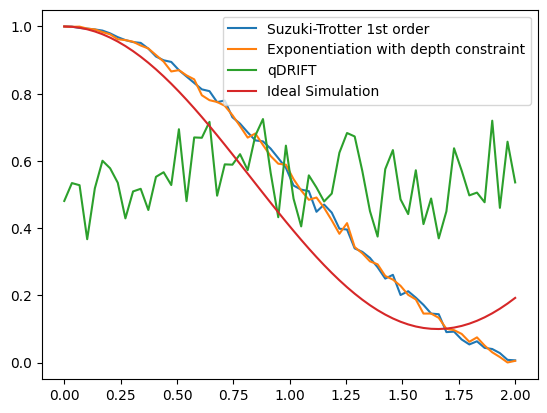

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.plot(time_list,magnetization_TS, label='Suzuki-Trotter 1st order')
plt.plot(time_list, magnetization_ewdc, label='Exponentiation with depth constraint')
plt.plot(time_list, magnetization_qdrift, label='qDRIFT')
plt.plot(time_list, ideal_magnetization, label='Ideal Simulation')
plt.legend()
plt.show()

As expected, exponentiation with depth constraint and Trotter-Suzuki give similar results since they are basically different stances of the same method. The qDRIFT returns less precise results in this case, which is also expected since this method performs well for hamiltonians with a large number of terms. 

# Summary and Exercises

In this guide, the Trotter-Suzuki and qDRIFT methods for hamiltonian simulation were introduced, highlighting the simplicity of Classiq's high level functional design in tackling complex problems.

To obtain more experience with the methods presented here, we suggest that you try to apply the following tutorial:

* [Hamiltonian Evolution for a Water Molecule](https://docs.classiq.io/latest/explore/tutorials/technology_demonstrations/hamiltonian_evolution/hamiltonian_evolution/)

It is encouraged to try and solving different molecules than the water molecule, with Classiq you can generate the hamiltonian of any valid molecule structure.

# Read More

Besides the methods presented in this guide, there are also mixed approaches. One of them, proposed by Matthew Hagan and Nathan Wiebe [[5]](#quantum_sim_paper), offer an interesting combination of the Trotter-Suzuki and qDRIFT methods.

# References

<a id='ts_paper'>[1]</a>: [Finding Exponential Product Formulas of Higher Orders (Naomichi Hatano and Masuo Suzuki)](https://arxiv.org/abs/math-ph/0506007)

<a id='qdrift_paper'>[2]</a>: [A random compiler for fast Hamiltonian simulation (Earl Campbell)](https://arxiv.org/abs/1811.08017)

<a id='qubitization_paper'>[3]</a>: [Hamiltonian Simulation by Qubitization (Guang Hao Low and Isaac L. Chuang)](https://arxiv.org/abs/1610.06546)

<a id='qsvt_paper'>[4]</a>: [Quantum singular value transformation and beyond: exponential improvements for quantum matrix arithmetics (András Gilyén, Yuan Su, Guang Hao Low, and Nathan Wiebe)](https://arxiv.org/abs/1806.01838)

<a id='quantum_sim_paper'>[5]</a>: [Composite Quantum Simulations (Matthew Hagan and Nathan Wiebe)](https://quantum-journal.org/papers/q-2023-11-14-1181/)